## Imports & Data Loading

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Build path to the processed training data
train_path = "../data/processed/train_processed.csv"

# 2. Load into a DataFrame
df_train = pd.read_csv(train_path)

# 3. Quick inspection
print("Train DataFrame shape:", df_train.shape)
df_train.head()

Train DataFrame shape: (5199, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,good
0,-0.775904,-0.226441,1.178781,1.199440,0.068358,2.144825,1.765922,0.624517,-0.169426,0.467230,-0.914025,1,1
1,-0.389287,-0.659067,-0.417431,-0.848574,0.127257,0.137470,0.679752,-0.425157,0.143998,0.195918,-0.830075,1,1
2,3.554210,-0.041030,1.178781,-0.430612,1.099083,1.341883,-0.637897,1.833636,0.520106,1.552481,0.177323,0,1
3,2.858299,-0.102834,1.386983,-0.764981,2.247604,-0.780179,-1.278915,0.883614,0.394736,1.620309,0.848921,0,1
4,-0.157317,-0.720870,-0.139829,-0.848574,-0.461729,-0.952238,-0.940600,-1.604379,-0.106741,-1.364131,1.268670,1,1


## Preparing feature & label arrays

In [54]:
# 4. Identify feature columns (all except 'good')
feature_cols = [col for col in df_train.columns if col != "good"]
print("Features now include:", feature_cols)

# 5. Convert to NumPy arrays
X_train = df_train[feature_cols].values
y_train = df_train["good"].values

# 6. Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


Features now include: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color']
X_train shape: (5199, 12)
y_train shape: (5199,)


## Defining & Testing the Sigmoid

In [57]:
def sigmoid(z):
    """
    Compute the sigmoid of z.

    For each element z_i, sigmoid(z_i) = 1 / (1 + exp(-z_i)).
    """
    return 1 / (1 + np.exp(-z))

# Quick test
test_vals = np.array([-2.0, 0.0, 2.0])
print("sigmoid([-2, 0, 2]) =", sigmoid(test_vals))


sigmoid([-2, 0, 2]) = [0.11920292 0.5        0.88079708]


## Loss Function

In [60]:
def compute_loss(y_true, y_pred):
    """
    Compute the average binary cross-entropy loss:
    
    L = -1/m * sum( y*log(y_pred) + (1-y)*log(1-y_pred) )
    where m = number of samples.
    """
    m = y_true.shape[0]
    # Clip y_pred to avoid log(0)
    eps = 1e-15
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    loss = - (1 / m) * np.sum(
        y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)
    )
    return loss

# Quick test
y_true = np.array([0, 1, 1, 0])
y_pred = np.array([0.1, 0.9, 0.8, 0.2])  # reasonable predictions
print("Loss (expected to be low):", compute_loss(y_true, y_pred))

y_pred_bad = np.array([0.9, 0.2, 0.1, 0.8])  # bad predictions
print("Loss (expected to be high):", compute_loss(y_true, y_pred_bad))


Loss (expected to be low): 0.164252033486018
Loss (expected to be high): 1.956011502714073


## Gradient

In [63]:
def compute_gradients(X, y_true, y_pred):
    """
    Compute gradients of the loss w.r.t. weights and bias.

    dw = (1/m) * X^T (y_pred - y_true)
    db = (1/m) * sum(y_pred - y_true)
    """
    m = y_true.shape[0]
    error = y_pred - y_true               # shape (m,)
    dw = (1 / m) * np.dot(X.T, error)     # shape (n_features,)
    db = (1 / m) * np.sum(error)          # scalar
    return dw, db

# Quick test on a small example
X_test = np.array([[1, 2],
                   [3, 4],
                   [5, 6]], dtype=float)
y_test = np.array([0, 1, 0])

# Make up some predictions via sigmoid of a linear model
w_test, b_test = np.array([0.1, -0.2]), 0.3
z_test = np.dot(X_test, w_test) + b_test
y_pred_test = sigmoid(z_test)

dw, db = compute_gradients(X_test, y_test, y_pred_test)
print("dw:", dw)
print("db:", db)


dw: [0.28568657 0.40284602]
db: 0.11715944752502339


## Defining the Class Skeleton

In [66]:
class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000):
        """
        lr: learning rate (step size)
        n_iters: number of training iterations
        """
        self.lr = lr               # learning rate
        self.n_iters = n_iters     # how many passes over the data
        self.w = None              # weights vector (will be numpy array of shape [n_features])
        self.b = None              # bias term (scalar)
        self.loss_history = []     # to record loss at each iteration


In [68]:
# Test to create a model instance
model = LogisticRegressionScratch(lr=0.1, n_iters=200)
print("Learning rate:", model.lr)
print("Iterations :", model.n_iters)
print("Initial w   :", model.w)
print("Initial b   :", model.b)


Learning rate: 0.1
Iterations : 200
Initial w   : None
Initial b   : None


## Implementing the fit() Function

In [136]:
import numpy as np

class LogisticRegressionScratch:
    def __init__(self, lr=0.01, n_iters=1000, reg_lambda=0.0):
        """
        lr: learning rate
        n_iters: number of training iterations
        reg_lambda: L2 regularization strength (λ)
        """
        self.lr = lr
        self.n_iters = n_iters
        self.reg_lambda = reg_lambda
        self.w = None
        self.b = None
        self.loss_history = []

    def fit(self, X, y):
        """
        Train logistic regression with L2 regularization.
        """
        m, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0

        for i in range(self.n_iters):
            # Linear combination
            z = X.dot(self.w) + self.b
            y_pred = sigmoid(z)

            # Unregularized loss
            loss = compute_loss(y, y_pred)
            # Add L2 penalty
            loss += (self.reg_lambda / (2 * m)) * np.sum(self.w ** 2)
            self.loss_history.append(loss)

            # Gradients (unregularized)
            error = y_pred - y
            dw = (1 / m) * X.T.dot(error)
            db = (1 / m) * np.sum(error)

            # Add L2 gradient term
            dw += (self.reg_lambda / m) * self.w

            # Parameter updates
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # Progress logging
            if (i + 1) % (self.n_iters // 5) == 0:
                print(f"Iter {i+1}/{self.n_iters}, loss={loss:.4f}")

    def predict_proba(self, X):
        return sigmoid(X.dot(self.w) + self.b)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)


In [138]:
# Smoke test with L2 on a small subset
X_sub, y_sub = X_train[:100], y_train[:100]
model_reg = LogisticRegressionScratch(lr=0.1, n_iters=200, reg_lambda=1.0)
model_reg.fit(X_sub, y_sub)
print("Final training loss with λ=1.0:", model_reg.loss_history[-1])


Iter 40/200, loss=0.1686
Iter 80/200, loss=0.0948
Iter 120/200, loss=0.0686
Iter 160/200, loss=0.0556
Iter 200/200, loss=0.0479
Final training loss with λ=1.0: 0.04788182522070512


In [103]:
# Instantiate and fit on the full training set
model = LogisticRegressionScratch(lr=0.1, n_iters=500)
model.fit(X_train, y_train)

Iteration 100/500, loss=0.5255
Iteration 200/500, loss=0.5136
Iteration 300/500, loss=0.5106
Iteration 400/500, loss=0.5096
Iteration 500/500, loss=0.5092


## Training Evaluation & Loss Curve

Training accuracy: 0.7438


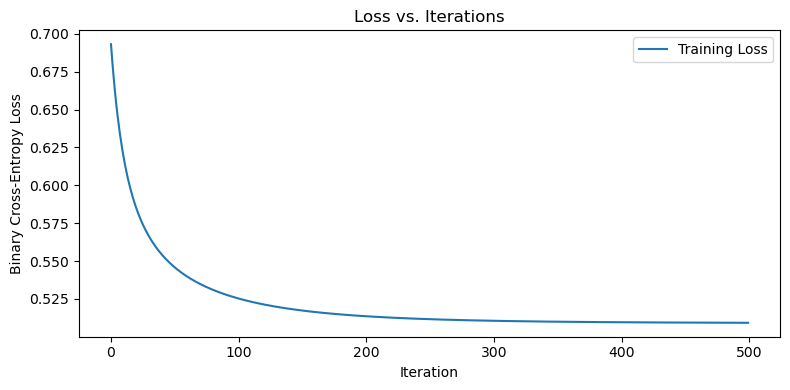

In [106]:
# 1. Predict on the training set
y_train_pred = model.predict(X_train)

# 2. Compute training accuracy
accuracy_train = np.mean(y_train_pred == y_train)
print(f"Training accuracy: {accuracy_train:.4f}")

# 3. Plot the loss history
plt.figure(figsize=(8, 4))
plt.plot(model.loss_history, label="Training Loss")
plt.title("Loss vs. Iterations")
plt.xlabel("Iteration")
plt.ylabel("Binary Cross-Entropy Loss")
plt.legend()
plt.tight_layout()
plt.show()


## Test‐Set Evaluation

In [109]:
# 1. Load the processed test set
test_path = "../data/processed/test_processed.csv"
df_test   = pd.read_csv(test_path)

# 2. Prepare X_test and y_test
X_test = df_test[feature_cols].values
y_test = df_test["good"].values

# 3. Predict on test set
y_test_pred = model.predict(X_test)

# 4. Compute accuracy
accuracy_test = np.mean(y_test_pred == y_test)

# 5. Compute precision, recall, and F1-score from scratch
tp = np.sum((y_test_pred == 1) & (y_test == 1))
tn = np.sum((y_test_pred == 0) & (y_test == 0))
fp = np.sum((y_test_pred == 1) & (y_test == 0))
fn = np.sum((y_test_pred == 0) & (y_test == 1))

precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score  = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# 6. Display results
print(f"Test Accuracy : {accuracy_test:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1-Score      : {f1_score:.4f}")

# 7. Optional: confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix:\n", cm)


Test Accuracy : 0.7196
Precision     : 0.7644
Recall        : 0.8054
F1-Score      : 0.7844

Confusion Matrix:
 [[272 204]
 [160 662]]


## Building a k-Fold Splitter

In [112]:
def k_fold_indices(m, k=5, seed=42):
    """
    Return a list of (train_idx, val_idx) tuples for k-fold CV.
    m = number of samples.
    """
    np.random.seed(seed)
    idx = np.arange(m)
    np.random.shuffle(idx)
    
    fold_sizes = (m // k) * np.ones(k, dtype=int)
    fold_sizes[: m % k] += 1  # distribute the remainder
    current = 0
    splits = []
    for fold_size in fold_sizes:
        start, stop = current, current + fold_size
        val_idx = idx[start:stop]
        train_idx = np.concatenate([idx[:start], idx[stop:]])
        splits.append((train_idx, val_idx))
        current = stop
    return splits

# Quick test
splits = k_fold_indices(10, k=5, seed=0)
for i, (tr, va) in enumerate(splits):
    print(f"Fold {i+1}: train={tr.tolist()}, val={va.tolist()}")


Fold 1: train=[4, 9, 1, 6, 7, 3, 0, 5], val=[2, 8]
Fold 2: train=[2, 8, 1, 6, 7, 3, 0, 5], val=[4, 9]
Fold 3: train=[2, 8, 4, 9, 7, 3, 0, 5], val=[1, 6]
Fold 4: train=[2, 8, 4, 9, 1, 6, 0, 5], val=[7, 3]
Fold 5: train=[2, 8, 4, 9, 1, 6, 7, 3], val=[0, 5]


## Defining Hyperparameter Grid

In [115]:
# We’ll tune only the learning rate for now:
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.2]
n_iters = 500  # fix iterations

results = []  # to store (lr, fold, val_accuracy)
splits = k_fold_indices(X_train.shape[0], k=5, seed=42)

print("Hyperparameter grid:", learning_rates)
print("Number of folds:", len(splits))


Hyperparameter grid: [0.001, 0.01, 0.05, 0.1, 0.2]
Number of folds: 5


## Running the CV Loop

In [118]:
for lr in learning_rates:
    for fold, (train_idx, val_idx) in enumerate(splits, start=1):
        # Prepare fold data
        X_tr, y_tr = X_train[train_idx], y_train[train_idx]
        X_va, y_va = X_train[val_idx], y_train[val_idx]
        
        # Train a fresh model on this fold
        clf = LogisticRegressionScratch(lr=lr, n_iters=n_iters)
        clf.fit(X_tr, y_tr)
        
        # Validate
        y_va_pred = clf.predict(X_va)
        acc = np.mean(y_va_pred == y_va)
        results.append((lr, fold, acc))
        print(f"lr={lr:.3f}, fold={fold}, val_acc={acc:.4f}")


Iteration 100/500, loss=0.6825
Iteration 200/500, loss=0.6727
Iteration 300/500, loss=0.6638
Iteration 400/500, loss=0.6558
Iteration 500/500, loss=0.6484
lr=0.001, fold=1, val_acc=0.6971
Iteration 100/500, loss=0.6820
Iteration 200/500, loss=0.6718
Iteration 300/500, loss=0.6626
Iteration 400/500, loss=0.6542
Iteration 500/500, loss=0.6466
lr=0.001, fold=2, val_acc=0.6779
Iteration 100/500, loss=0.6823
Iteration 200/500, loss=0.6724
Iteration 300/500, loss=0.6634
Iteration 400/500, loss=0.6552
Iteration 500/500, loss=0.6477
lr=0.001, fold=3, val_acc=0.6885
Iteration 100/500, loss=0.6827
Iteration 200/500, loss=0.6732
Iteration 300/500, loss=0.6645
Iteration 400/500, loss=0.6566
Iteration 500/500, loss=0.6493
lr=0.001, fold=4, val_acc=0.6971
Iteration 100/500, loss=0.6822
Iteration 200/500, loss=0.6721
Iteration 300/500, loss=0.6630
Iteration 400/500, loss=0.6547
Iteration 500/500, loss=0.6472
lr=0.001, fold=5, val_acc=0.6978
Iteration 100/500, loss=0.6200
Iteration 200/500, loss=0.586

## Aggregating & Visualizing Cross-Validation Results

      lr      mean       std
0  0.001  0.691673  0.008617
1  0.010  0.722446  0.009386
2  0.050  0.740718  0.008769
3  0.100  0.741679  0.010704
4  0.200  0.744564  0.010887


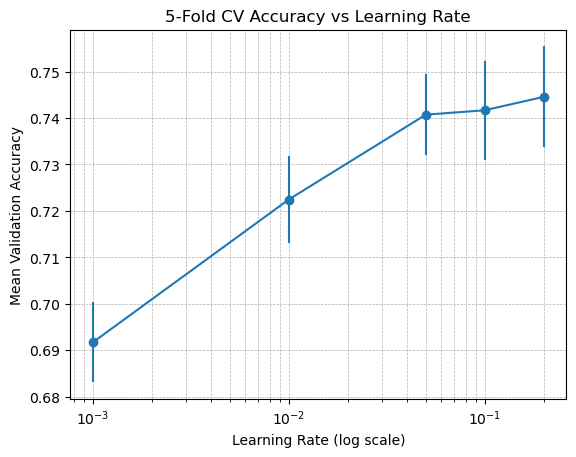

In [121]:
# Build a DataFrame from results
cv_df = pd.DataFrame(results, columns=["lr", "fold", "val_acc"])

# Compute mean & std acc per learning rate
summary = cv_df.groupby("lr")["val_acc"].agg(["mean", "std"]).reset_index()
print(summary)

# Plot
plt.errorbar(summary["lr"], summary["mean"], yerr=summary["std"], fmt='-o')
plt.xscale('log')
plt.title("5-Fold CV Accuracy vs Learning Rate")
plt.xlabel("Learning Rate (log scale)")
plt.ylabel("Mean Validation Accuracy")
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()


## Selecting Best Hyperparameter & Retraining

In [124]:
# Pick the lr with highest mean val_acc
best_lr = summary.loc[summary["mean"].idxmax(), "lr"]
print(f"Best learning rate = {best_lr}")

# Retrain on the full training set
best_model = LogisticRegressionScratch(lr=best_lr, n_iters=n_iters)
best_model.fit(X_train, y_train)


Best learning rate = 0.2
Iteration 100/500, loss=0.5136
Iteration 200/500, loss=0.5096
Iteration 300/500, loss=0.5091
Iteration 400/500, loss=0.5089
Iteration 500/500, loss=0.5088


## Evaluating Best Model on Test Set

In [127]:
y_test_pred = best_model.predict(X_test)
acc_test    = np.mean(y_test_pred == y_test)
print("Test Accuracy (best lr):", acc_test)
# Compute confusion‐matrix counts
tp = np.sum((y_test_pred == 1) & (y_test == 1))
tn = np.sum((y_test_pred == 0) & (y_test == 0))
fp = np.sum((y_test_pred == 1) & (y_test == 0))
fn = np.sum((y_test_pred == 0) & (y_test == 1))

# Compute metrics
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall    = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score  = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Test Precision: {precision:.4f}")
print(f"Test Recall   : {recall:.4f}")
print(f"Test F1-Score : {f1_score:.4f}")

# (Optional) Display confusion matrix
print("\nConfusion Matrix (tn, fp; fn, tp):")
print([[tn, fp],
       [fn, tp]])


Test Accuracy (best lr): 0.7187981510015409
Test Precision: 0.7642
Test Recall   : 0.8041
Test F1-Score : 0.7836

Confusion Matrix (tn, fp; fn, tp):
[[272, 204], [161, 661]]
